# NDP Song Lyric Generation (using RNN LSTM)

_Inspired by [Text generation with an RNN](https://www.tensorflow.org/tutorials/text/text_generation)_

In [ ]:
# codes to mount your google drive folder
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/Othercomputers/My Computer (1)/CS605_NLP_for_Smart_Assistants/Project/NLP-Lyric-Generator/src/bin

## Import dependencies

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os
import re
import sys

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from PIL import Image
from sklearn.model_selection import train_test_split

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.7.12
Tensorflow version: 2.6.3
Keras version: 2.6.0


In [ ]:
### Custom Imports
sys.path.append('../')
import lib.utilities as utils

## Download the dataset

In [2]:
PATH = '../../data'

In [3]:
dataset_file_names = os.listdir(PATH)
dataset_file_names[:5]

['Someone Someday.txt',
 'I Love Singapore.txt',
 'We Will Get There.txt',
 'Shine for Singapore.txt',
 'There_s A Part For Everyone.txt']

In [4]:
corpus = ''
for i,file in enumerate(dataset_file_names):
    text = open(PATH + '/' + file, mode='r').read()
    if i == 0:
        corpus += text
    else:
        corpus = corpus + '\n\n' + text

## Analyze the dataset

In [6]:
print('Length of Corpus: {} characters'.format(len(corpus)))

Length of Corpus: 56772 characters


In [7]:
# Take a look at the first 1000 characters in text.
print(corpus[:1000])

<VERSE>
Didn't they used to say we're ordinary
Didn't we take it as that and put ourselves down
Don't we all don't we all think it's necessary
To prove to them that we'll be
We'll be someone someday
Aren't you tired so very tired of waiting
For something else someone else to give us a hand
Pick yourself up pick yourself up get ready
We'll go make a difference
We'll be someone someday

<CHORUS>
That's right we'll make you proud of us
You and me
That means that we should be happy
Let it come to us naturally

<VERSE>
Look around look around us
Weren't there many 
who patronised contradict us and pushed us aside
Recognise realise start believing
Sure there'll be some despair
But don't let yourself fall

<VERSE>
It's now a quarter of a century
We have worked so hard now just to be free
Through all the heartaches and the pains
We have stood through all the many many changes
In our hearts we have become like family
Can't you see, yeah, can't you see, ooh

<VERSE>
We have only what we have in 

In [8]:
# clean corpus
corpus_clean = utils.decontraction(corpus)
corpus_clean = utils.remove_punct(corpus_clean, '\<|\>')

# tokenize and count the number of words
corpus_clean = re.sub('\n\n', '\n', corpus_clean)
corpus_clean = re.sub('\n', ' \n ', corpus_clean)
tokens = re.split(' ', corpus_clean)
tokens_clean = []
structures = ['<BRIDGE>', '<CHORUS>', '<OTHERS>', '<PRECHORUS>', '<PRELUDE>', '<VERSE>']
for i,t in enumerate(tokens):
    if t:                                  # remove empty strings
        if i < len(tokens)-1 and t == '\n' and tokens[i+1] in structures:
            tokens_clean.append('\n\n')    # change to double line break for token before structure 
        elif t not in structures:
            tokens_clean.append(t.lower()) # lower case if not structure tokens
        else:
            tokens_clean.append(t)
    
print('Length of Corpus: {} words'.format(len(tokens_clean)))

# The unique words in the file
vocab = sorted(set(tokens_clean))
print('Vocab Size:', len(vocab))
print('Vocab Examples:', tokens_clean[:20])

Length of Corpus: 13476 words
Vocab Size: 1048
Vocab Examples: ['<VERSE>', '\n', 'did', 'not', 'they', 'used', 'to', 'say', 'we', 'are', 'ordinary', '\n', 'did', 'not', 'we', 'take', 'it', 'as', 'that', 'and']


In [9]:
print(tokens_clean[:100])

['<VERSE>', '\n', 'did', 'not', 'they', 'used', 'to', 'say', 'we', 'are', 'ordinary', '\n', 'did', 'not', 'we', 'take', 'it', 'as', 'that', 'and', 'put', 'ourselves', 'down', '\n', 'do', 'not', 'we', 'all', 'do', 'not', 'we', 'all', 'think', 'it', 'is', 'necessary', '\n', 'to', 'prove', 'to', 'them', 'that', 'we', 'will', 'be', '\n', 'we', 'will', 'be', 'someone', 'someday', '\n', 'are', 'not', 'you', 'tired', 'so', 'very', 'tired', 'of', 'waiting', '\n', 'for', 'something', 'else', 'someone', 'else', 'to', 'give', 'us', 'a', 'hand', '\n', 'pick', 'yourself', 'up', 'pick', 'yourself', 'up', 'get', 'ready', '\n', 'we', 'will', 'go', 'make', 'a', 'difference', '\n', 'we', 'will', 'be', 'someone', 'someday', '\n\n', '<CHORUS>', '\n', 'that', 'is', 'right']


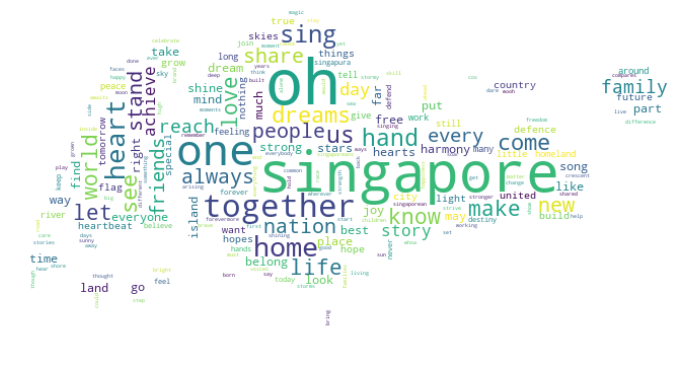

In [10]:
# Unigram Word Cloud

# remove stopwords
stop = set(stopwords.words('english'))
stop.update(structures)
stop.update(['\n', '\n\n'])
tokens_no_stopwords = [t for t in tokens_clean if t not in stop]

corpus_dict = {}
for word in tokens_no_stopwords:
    corpus_dict[word] = corpus_dict.get(word, 0) + 1

sg_mask = np.array(Image.open("../input/ndp-songs/singaporemap.png"))
my_cloud = WordCloud(background_color='white', stopwords=stop, mask=sg_mask).generate_from_frequencies(corpus_dict)

plt.figure(figsize=(12,10))
plt.imshow(my_cloud, interpolation='bilinear') 
plt.axis('off')
plt.show()

## Process the dataset

### Vectorize the text

Before feeding the text to our RNN we need to convert the text from a sequence of characters to a sequence of numbers. To do so we will detect all unique characters in the text, form a vocabulary out of it and replace each character with its index in the vocabulary.

In [11]:
# get word and indices mapping
word_indices = {}
indices_word = {}
for i, w in enumerate(sorted(set(tokens_clean))):
    word_indices[w] = i
    indices_word[i] = w

In [12]:
# convert data to indices numbers (vectorize):
tokens_clean = np.array(tokens_clean)
tokens_clean_idx = np.vectorize(word_indices.get)(tokens_clean)

### Create sequences

In [13]:
word_dataset = tf.data.Dataset.from_tensor_slices(tokens_clean_idx)

2022-05-26 11:02:44.007938: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 11:02:44.134166: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 11:02:44.134932: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 11:02:44.137157: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [14]:
SEQUENCE_LEN = 15
sequences = word_dataset.window(SEQUENCE_LEN + 1, 1, drop_remainder=True)

for window in sequences.take(3):
    print(repr(' '.join(np.vectorize(indices_word.get)(np.array(list(window.as_numpy_iterator()))))))

'<VERSE> \n did not they used to say we are ordinary \n did not we take'
'\n did not they used to say we are ordinary \n did not we take it'
'did not they used to say we are ordinary \n did not we take it as'


2022-05-26 11:02:46.909024: W tensorflow/core/framework/dataset.cc:679] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-05-26 11:02:46.924725: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-05-26 11:02:46.930717: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


In [15]:
sequences = sequences.flat_map(lambda window: window.batch(SEQUENCE_LEN + 1))
for elem in sequences.take(3):
    print(elem)


tf.Tensor([  7   0 232 585 878 950 897 723 978  45 607   0 232 585 978 855], shape=(16,), dtype=int64)
tf.Tensor([  0 232 585 878 950 897 723 978  45 607   0 232 585 978 855 448], shape=(16,), dtype=int64)
tf.Tensor([232 585 878 950 897 723 978  45 607   0 232 585 978 855 448  50], shape=(16,), dtype=int64)


2022-05-26 11:02:47.176031: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [16]:
sequences = sequences.map(lambda window: (window[:-1], window[-1:]))
X_train = sequences.map(lambda X,y: X)
y_train = sequences.map(lambda X,y: y)

for elem1, elem2 in zip(X_train.take(3), y_train.take(3)):
    print(elem1, '----->', elem2)

tf.Tensor([  7   0 232 585 878 950 897 723 978  45 607   0 232 585 978], shape=(15,), dtype=int64) -----> tf.Tensor([855], shape=(1,), dtype=int64)
tf.Tensor([  0 232 585 878 950 897 723 978  45 607   0 232 585 978 855], shape=(15,), dtype=int64) -----> tf.Tensor([448], shape=(1,), dtype=int64)
tf.Tensor([232 585 878 950 897 723 978  45 607   0 232 585 978 855 448], shape=(15,), dtype=int64) -----> tf.Tensor([50], shape=(1,), dtype=int64)


In [17]:
print('dataset size: {}'.format(len(list(sequences.as_numpy_iterator()))))

dataset size: 13461


In [18]:
BATCH_SIZE = 64

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
BUFFER_SIZE = 10000

AUTOTUNE = tf.data.AUTOTUNE
dataset = sequences.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(buffer_size=AUTOTUNE)

print('Batched dataset size: {}'.format(len(list(dataset.as_numpy_iterator()))))

Batched dataset size: 210


In [19]:
# def create_sequences(tokens, sequence_len, step=1):
#     """Create pairs of sequences and next word 

#     Args: 
#       tokens (list): list containing tokens in sequence
#       sequence_len (int): length of each created sequence
#       step (int): number of steps to take after creating each sequence
    
#     Returns:
#       sentences (list) list of sequences in same order as next_words
#       next_words (list) list of next words in same order as sentences
#     """
    
#     sentences = []
#     next_words = []

#     for i in range(0, len(tokens) - sequence_len, step):
#         sentences.append(tokens[i: i + sequence_len])
#         next_words.append(tokens[i + sequence_len])
        
#     return sentences, next_words


# STEP = 1
# SEQUENCE_LEN = 15

# sentences, next_words = create_sequences(tokens_clean_idx, SEQUENCE_LEN, STEP)
# print('Number of sequences created:', len(sentences))

In [20]:
# SEED = 2022
# X_train, X_test, Y_train, Y_test = train_test_split(sentences, next_words, train_size=0.8, random_state=SEED)
# print('Training size:', len(X_train))
# print('Testing size:', len(X_test))

### Build and Test Model

In [21]:
VOCAB_SIZE = len(vocab)
EMBEDDINGG_DIM = 256
RNN_UNITS = 1024

EPOCHS=100
LR = 0.001

In [22]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    """Build Keras Model

    Args: 
      vocab_size (int): size of vocabulary of corpus
      embedding_dim (int): dimension of word embedding matrix
      rnn_units (int): number of neurons in rnn
      batch_size (int): batch size 

    
    Returns:
      Keras sequential model 
    """
    
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
      units=rnn_units,
      return_sequences=False,
#       stateful=True,
      recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))


    model.add(tf.keras.layers.Dense(vocab_size))
  
    return model


model = build_model(VOCAB_SIZE, EMBEDDINGG_DIM, RNN_UNITS, BATCH_SIZE)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           268288    
_________________________________________________________________
lstm (LSTM)                  (64, 1024)                5246976   
_________________________________________________________________
dense (Dense)                (64, 1048)                1074200   
Total params: 6,589,464
Trainable params: 6,589,464
Non-trainable params: 0
_________________________________________________________________


In [23]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

2022-05-26 11:02:55.701564: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


(64, 1048) # (batch_size, sequence_length, vocab_size)


In [24]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    """Compute the loss from outputed logits of model

    Args: 
      labels (list): y labels / ground truth
      logits (list): logits outputed by the model
    
    Returns:
      Loss score
    """
    
    return tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 1048)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       6.953533


In [25]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
model.compile(
    optimizer=adam_optimizer,
    loss=loss
)

In [26]:
# Directory where the checkpoints will be saved.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

### Train Model

In [27]:
history = model.fit(
  x=dataset,
  epochs=EPOCHS,
  callbacks=[
    checkpoint_callback
  ]
)

Epoch 1/100
210/210 [==============================] - 4s 10ms/step - loss: 5.1257
Epoch 2/100
210/210 [==============================] - 2s 10ms/step - loss: 4.3055
Epoch 3/100
210/210 [==============================] - 2s 10ms/step - loss: 3.5706
Epoch 4/100
210/210 [==============================] - 2s 10ms/step - loss: 2.8095
Epoch 5/100
210/210 [==============================] - 2s 10ms/step - loss: 2.0525
Epoch 6/100
210/210 [==============================] - 2s 10ms/step - loss: 1.3827
Epoch 7/100
210/210 [==============================] - 2s 10ms/step - loss: 0.8839
Epoch 8/100
210/210 [==============================] - 2s 10ms/step - loss: 0.5635
Epoch 9/100
210/210 [==============================] - 2s 11ms/step - loss: 0.3692
Epoch 10/100
210/210 [==============================] - 2s 11ms/step - loss: 0.2612
Epoch 11/100
210/210 [==============================] - 2s 10ms/step - loss: 0.1819
Epoch 12/100
210/210 [==============================] - 2s 10ms/step - loss: 0.1489
E

### Restore the latest checkpoint

To keep this prediction step simple, use a batch size of 1.

Because of the way the RNN state is passed from timestep to timestep, the model only accepts a fixed batch size once built.

To run the model with a different `batch_size`, we need to rebuild the model and restore the weights from the checkpoint.

In [28]:
tf.train.latest_checkpoint(checkpoint_dir)

'tmp/checkpoints/ckpt_100'

In [29]:
simplified_batch_size = 1

model = build_model(VOCAB_SIZE, EMBEDDINGG_DIM, RNN_UNITS, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([simplified_batch_size, None]))

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            268288    
_________________________________________________________________
lstm_1 (LSTM)                (None, 1024)              5246976   
_________________________________________________________________
dense_1 (Dense)              (None, 1048)              1074200   
Total params: 6,589,464
Trainable params: 6,589,464
Non-trainable params: 0
_________________________________________________________________


### The prediction loop

The following code block generates the text:

- It Starts by choosing a start string, initializing the RNN state and setting the number of words to generate.

- Get the prediction distribution of the next word using the start string and the RNN state.

- Then, use a categorical distribution to calculate the index of the predicted character. Use this predicted word as our next input to the model.

- The RNN state returned by the model is fed back into the model so that it now has more context, instead than only one word. After predicting the next word, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted words.

In [31]:
# num_generate
# - number of words to generate.
#
# temperature

# - Experiment to find the best setting.
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    """Generate text using trained sequential text generation model

    Args: 
      model (model): Keras trained sequential text generation model
      start_string (list): list of strings for starting the text generation
      num_generate (int): number of words to generate
      temperature (float): controls the predictability of the generated text
        - Low temperatures results in more predictable text.
        - Higher temperatures results in more surprising text.
    
    Returns:
      String of generated text
      
    """

    # Converting our start string to numbers (vectorizing).
    input_indices = [word_indices[s] for s in start_string]
    input_indices = tf.expand_dims(input_indices, 0)

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for word_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predictions = tf.reshape(predictions, [1, predictions.shape[0]])
        predicted_id = tf.random.categorical(
            predictions,
            num_samples=1
            )[-1,0].numpy()

        # We pass the predicted word as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)

        text_generated.append(indices_word[predicted_id])
    
    return (' '.join(start_string) + ' ' + ' '.join(text_generated))

In [32]:
# Generate the text with default temperature (1.0).
print(generate_text(model, start_string=['<CHORUS>', '\n'], num_generate=30))

<CHORUS> 
 we are the world 

 <VERSE> 
 together we will you and there is a nation is a hand in a new beginning by the nation singapore 
 what i


In [33]:
# Generate the text with default temperature (1.0).
print(generate_text(model, start_string=['<CHORUS>', '\n'], num_generate=30))

<CHORUS> 
 we will be 
 and everyone is a new beginning i’m the world will you will be 
 our home to be 
 and there is a new beginning together


In [34]:
# Generate the text with default temperature (1.0).
print(generate_text(model, start_string=['<VERSE>', '\n'], num_generate=30))

<VERSE> 
 i have a new world can be world will be 
 there is a towards a thousand what we will you are singapore 
 the vision place i will be


In [35]:
# Generate the text with default temperature (1.0).
print(generate_text(model, start_string=['<VERSE>', '\n'], num_generate=30))

<VERSE> 
 find a new heights 
 what we are my home for singapore 

 <VERSE> 
 together 
 our home to a new world will be 
 tomorrow is a moon


In [36]:
# Generate the text with higher temperature to get more unexpected results.
print(generate_text(model, start_string=['<CHORUS>', '\n'], num_generate=30, temperature=1.5))
print(generate_text(model, start_string=['<CHORUS>', '\n'], num_generate=30, temperature=1.5))
print(generate_text(model, start_string=['<VERSE>', '\n'], num_generate=30, temperature=1.5))
print(generate_text(model, start_string=['<VERSE>', '\n'], num_generate=30, temperature=1.5))

<CHORUS> 
 nothing in my heart to keep so moon is a new 
 together 
 your heart our everyone is our home 
 and shining key 
 when i will be
<CHORUS> 
 this is to be 
 together 
 to keep so new stories 
 if we have when i have forever 
 city through the spirit you can be 
 the
<VERSE> 
 words i have a brand beautiful beginning top i will be there are the brand shine 

 on have world will be kind some braver write out of the so
<VERSE> 
 mirth is my home that is the world dozen wave our home <CHORUS> 
 and there are the light belongs 
 our home us be on a new story 



## Save the model

In [37]:
model_name = 'text_generation_lstm_word_level.h5'
model.save(model_name, save_format='h5')

## Converting the model to web-format

To use this model on the web we need to convert it into the format that will be understandable by [tensorflowjs](https://www.tensorflow.org/js). To do so we may use [tfjs-converter](https://github.com/tensorflow/tfjs/tree/master/tfjs-converter) as following:

```
tensorflowjs_converter --input_format keras \
  ./experiments/text_generation_shakespeare_rnn/text_generation_shakespeare_rnn.h5 \
  ./demos/public/models/text_generation_shakespeare_rnn
```

You find this experiment in the [Demo app](https://trekhleb.github.io/machine-learning-experiments) and play around with it right in you browser to see how the model performs in real life.